**Data**

The objective of this project is to identify phishing-like emails in a group of mixed emails. Data is from the following Kaggle dataset: https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset

In [3]:
import pandas as pd
import nltk
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#from nltk.tokenize import WordTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.pipeline import Pipeline
from nltk import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.sparse import hstack
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
df_ceas = pd.read_csv('archive/CEAS_08.csv')

In [5]:
df_ceas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    39154 non-null  object
 1   receiver  38692 non-null  object
 2   date      39154 non-null  object
 3   subject   39126 non-null  object
 4   body      39154 non-null  object
 5   label     39154 non-null  int64 
 6   urls      39154 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.1+ MB


Due to having little relevence, the date and receiver columns will be dropped. The prevalance of formerly-legitimate and abandoned accounts being hijacked to send dangerous emails also means the exact identity of the sender is irrelevant.

In [7]:
df = df_ceas.drop(columns = ['date','sender','receiver']).dropna() #intuitively, date has no predictive value on the safety of an email, and neither does receiver

In [8]:
df.head()

,subject,body,label,urls
0,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


After dropping entries with null data, the final dataframe has 39153 rows and 4 columns. The 'label' column is the target column to be predicted based on other columns, where '1' means the email is dangerous and '0' means it is safe.

**Data Exploration**

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39126 entries, 0 to 39153
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  39126 non-null  object
 1   body     39126 non-null  object
 2   label    39126 non-null  int64 
 3   urls     39126 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.5+ MB


A deeper look into the data reveals that most of the emails are marked as phishing emails. 

Text(0.5, 0, 'Email Type')

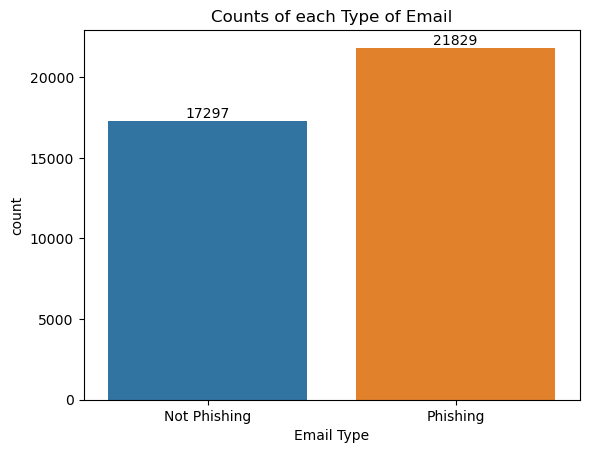

In [13]:
df['urls'] = df['urls'].astype(str)
ax = sns.countplot(data = df, x = 'label')
ax.bar_label(ax.containers[0]);
ax.set_title('Counts of each Type of Email')
plt.xticks(ticks=[0, 1], labels=['Not Phishing', 'Phishing'])
plt.xlabel("Email Type")

**Links and Sign Ins**

A tactic phishing emails sometimes use is to ask the user to login at a particular link, which leads the user to a website that looks like the official website the email is pretending to be from. The user then enters their credentials and the attacker obtains both. As such, any emails that have a link or ask a user to sign in somewhere should receive heightened attention.

The below plot shows the presence of an URL does not seem to indicate a much more risky email than not.

Text(0.5, 0, 'Email Type')

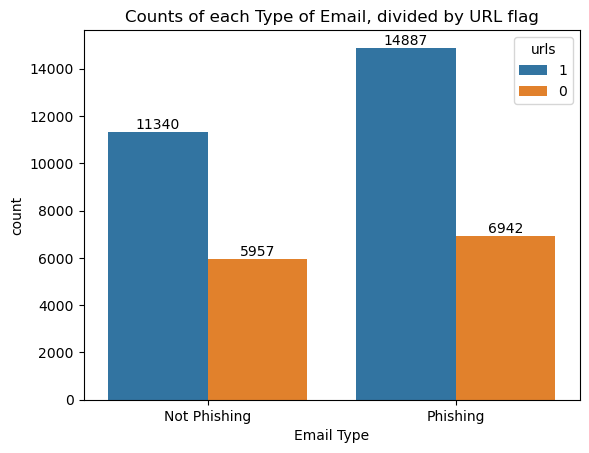

In [15]:
df['urls'] = df['urls'].astype(str)
ax = sns.countplot(data = df, x = 'label',hue = 'urls')
for i in ax.containers:
    ax.bar_label(i,)
ax.set_title('Counts of each Type of Email, divided by URL flag')
plt.xticks(ticks=[0, 1], labels=['Not Phishing', 'Phishing'])
plt.xlabel("Email Type")

Same plot for 'sign in.' It was found that "sign in" alone gave better results than any combination of itself and other phrases such as "log in," but despite that, it still remained a tiny presence amongst all the other emails.

In [17]:
keywordlogin = ['sign in']
pattern = '|'.join(keywordlogin)
df['signin'] = df.body.str.contains(pattern).astype(str)

Text(0.5, 0, 'Email Type')

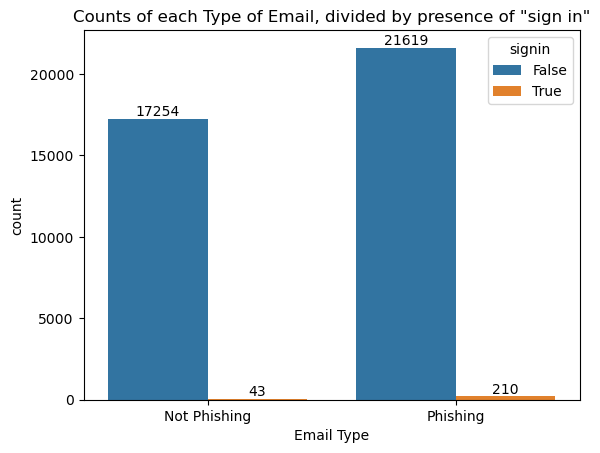

In [18]:
ax = sns.countplot(data = df, x = 'label',hue = 'signin')
for i in ax.containers:
    ax.bar_label(i,)
ax.set_title('Counts of each Type of Email, divided by presence of \"sign in\"')
plt.xticks(ticks=[0, 1], labels=['Not Phishing', 'Phishing'])
plt.xlabel("Email Type")

Text(0.5, 0, 'Email Type')

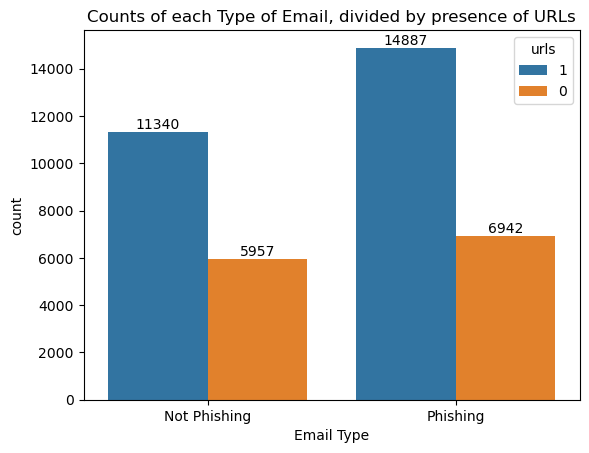

In [19]:
ax = sns.countplot(data = df, x = 'label',hue = 'urls')
for i in ax.containers:
    ax.bar_label(i,)
ax.set_title('Counts of each Type of Email, divided by presence of URLs')
plt.xticks(ticks=[0, 1], labels=['Not Phishing', 'Phishing'])
plt.xlabel("Email Type")

**Message Length**

Phishing emails also tend to be shorter to give the reader less time to really consider whether it is legitimate or not, so message length is another metric that can be explored:

In [21]:
df['length'] = df.apply(lambda x: len(x['body']),axis=1)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(0.0, 10000.0)

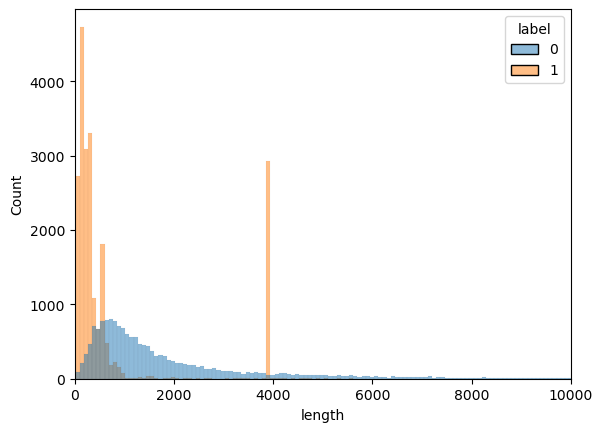

In [22]:
fig, ax = plt.subplots()
sns.histplot(data = df, x = 'length',hue='label')
ax.set_xlim(0, 10000)

As it turns out, shorter messages are indeed more dangerous than longer ones in this dataset.

**Data Processing**

To make the data suitable for models to use, the message body in particular must be tokenized and reduced to root forms.

In [25]:
#lemmetize, stemmer
def stemmer(text):
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(w) for w in nltk.word_tokenize(text)])

In [26]:
start = time.time()
stemmed_content = df['body'].apply(stemmer)
end = time.time()
print(end-start)

145.53460788726807


In [27]:
cvect = CountVectorizer(stop_words = 'english',max_features = 500)
dtm = cvect.fit_transform(stemmed_content)

The additional features from metadata must also be added:

In [29]:
X = hstack((dtm,np.array(df['length'])[:,None])).tocsr() #adding body message length
X = hstack((X,np.array(df['urls'].astype('int64'))[:,None])).tocsr() #adding url flag

y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [30]:
pd.DataFrame(X.toarray(), columns = np.append(cvect.get_feature_names_out(),['length','urls'])).head()

,00,000,01,02,03,04,05,06,07,08,...,workshop,world,write,wrote,www,yahoo,ye,year,length,urls
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,273,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,82,1
2,0,0,16,0,0,0,0,0,4,16,...,0,5,0,0,23,0,0,0,3918,1
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,1,376,0,2,0,24418,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,175,1


**Model Training**

Logistic Regression, Decision Tree, and Naive Bayes will be tried on the above dataset.

**Logistical Regression**

In [32]:
model = LogisticRegression()
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']
c_values = [0.1,1,10]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
lr_grid = GridSearchCV(estimator=model, param_grid=grid)
start = time.time()
lr_result = lr_grid.fit(X_train, y_train)
end = time.time()
test_acc = lr_result.score(X_test,y_test)

In [33]:
preds = lr_result.best_estimator_.predict(X_test)
print("Best: %f using %s" % (lr_result.best_score_, lr_result.best_params_))
lr_score = lr_result.score(X_test,y_test)
lr_time = end- start
print(lr_score)
print(lr_time, "seconds")

Best: 0.984937 using {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.9842567982007769
37.873743772506714 seconds


Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

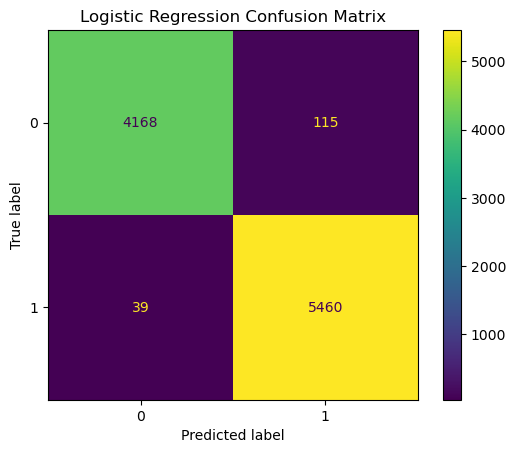

In [34]:
lr_preds = lr_result.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix(y_test, lr_preds)).plot()
plt.grid(False)
plt.title("Logistic Regression Confusion Matrix")

Only allowing 39 dangerous emails and blocking 115 safe emails in about 10,000 emails is quite impressive.

**DecisionTree Classifier**

The next model considered is the DecisionTreeClassifier. Unlike the other models, the best accuracy can intuitively be obtained by not limiting max_depth, but there is some danger of overfitting doing so.

In [37]:
model = DecisionTreeClassifier()
min_samples_split = [4,6,8]
max_depth = [26,28,30,None]
grid = dict(min_samples_split=min_samples_split,max_depth=max_depth)
dec_grid = GridSearchCV(estimator=model, param_grid=grid) 
start = time.time()
dec_result = dec_grid.fit(X_train, y_train)
end = time.time()

In [38]:
print("Best: %f using %s" % (dec_result.best_score_, dec_result.best_params_))
dt_score = dec_result.score(X_test,y_test)
dt_time = end - start
print(dt_score)
print(dt_time)

Best: 0.979825 using {'max_depth': 26, 'min_samples_split': 4}
0.979758740543856
49.847867012023926


Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

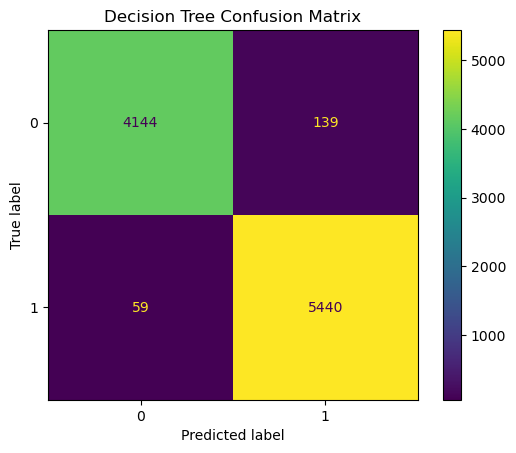

In [39]:
tree_preds = dec_result.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix(y_test, tree_preds)).plot()
plt.grid(False)
plt.title("Decision Tree Confusion Matrix")

With only allowing 72 dangerous emails and blocking 114 safe emails in about 10,000 emails in the test data, it seems that overfitting did not seem to be an issue.

**Naive Bayes**

In [42]:
model = MultinomialNB()
alphas = [0.001,0.01,0.1,1,10,100,1000,10_000]
grid = dict(alpha=alphas)
by_grid = GridSearchCV(estimator=model, param_grid=grid)
start = time.time()
by_result = by_grid.fit(X_train, y_train)
end = time.time()

In [43]:
preds = by_result.best_estimator_.predict(X_test)
print("Best: %f using %s" % (by_result.best_score_, by_result.best_params_))
by_score = by_result.score(X_test,y_test)
by_time = end-start
print(by_score)
print(by_time, "seconds")

Best: 0.727406 using {'alpha': 1}
0.7331833980781026
0.5470459461212158 seconds


Text(0.5, 1.0, 'Naive Bayes Confusion Matrix')

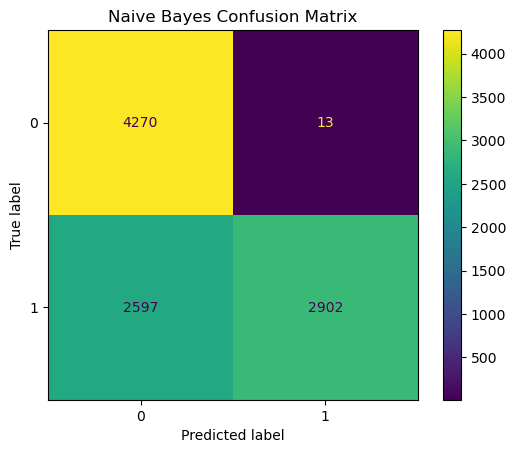

In [44]:
by_preds = by_result.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix(y_test, by_preds)).plot()
plt.grid(False)
plt.title("Naive Bayes Confusion Matrix")

Naive Bayes performed much worse than the previous 2 models, allowing 2597 dangerous emails through. Overall, it was much more lenient, blocking only 13 safe emails.

In [46]:
pd.DataFrame({'model': ['Logistic Regression', 'Decision Tree', 'Bayes'], 
             'best_params': [lr_result.best_params_, dec_result.best_params_, by_result.best_params_],
             'best_score': [lr_score, dt_score, by_score]}).set_index('model')

,best_params,best_score
model,,
Logistic Regression,"{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}",0.984257
Decision Tree,"{'max_depth': 26, 'min_samples_split': 4}",0.979759
Bayes,{'alpha': 1},0.733183


**Conclusion**

Overall, Logistic Regression and Decision Tree were able to achieve very high levels of accuracy of above 98%. 
Given decision tree's tendancy to overfit, I suspect Logistic Regression would be able to scale better on new emails, but both models worked quite well on what was available.